In [121]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [122]:
def f(x):
    return 3*x**2 - 4*x + 5

In [123]:
f(3.0)

20.0

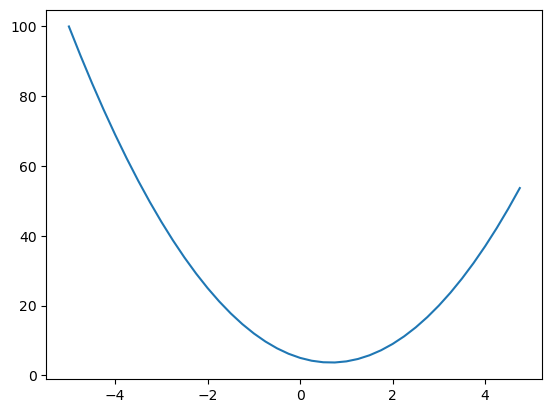

In [124]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [125]:
h = 0.000001
x = 2/3
(f(x+h) - f(x)) / h

2.999378523327323e-06

In [126]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c

In [127]:
print(d)

4.0


In [128]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
a += h
d2 = a*b + c

print('d1: ', d1)
print('d2: ', d2)
print('slope: ', (d2 - d1)/h)

d1:  4.0
d2:  3.999699999999999
slope:  -3.000000000010772


In [129]:
class Value:
    def __init__(self, data, _children=(), _op='', label='', grad=0):
        self.grad = 0.0
        self.data = data
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __rmul__(self, other):
        return self * other

    def __neg__(self):
        return self * -1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supports int/float powers for now"
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad

        out._backward = _backward
        
        return out

    def __truediv__(self, other):
        return self * other**-1

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1
        for node in reversed(topo):
            node._backward()

a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b
e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f; L.label = 'L'
d

Value(data=4.0)

In [130]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [131]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad ), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

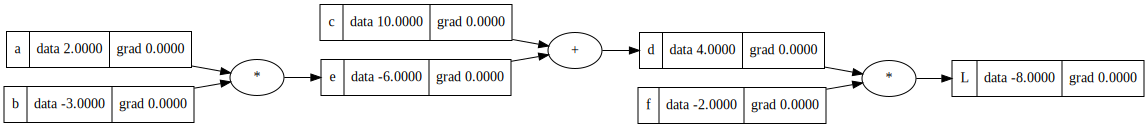

In [132]:
draw_dot(L)

In [133]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = d.grad * 1
e.grad = d.grad * 1
b.grad = e.grad * a.data
a.grad = e.grad * b.data

In [134]:
# Take advantage of knowledge of gradients to reduce loss function
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f; L.label = 'L'
print(L.data)

-34.463072


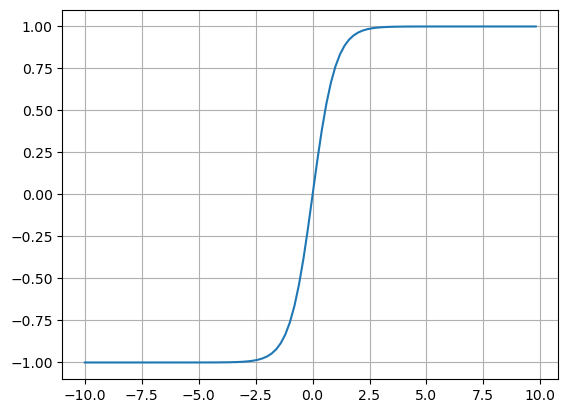

In [135]:
plt.plot(np.arange(-10,10,0.2), np.tanh(np.arange(-10,10,0.2)))
plt.grid()

In [136]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8814, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'neuron'

o = n.tanh(); o.label = 'o'

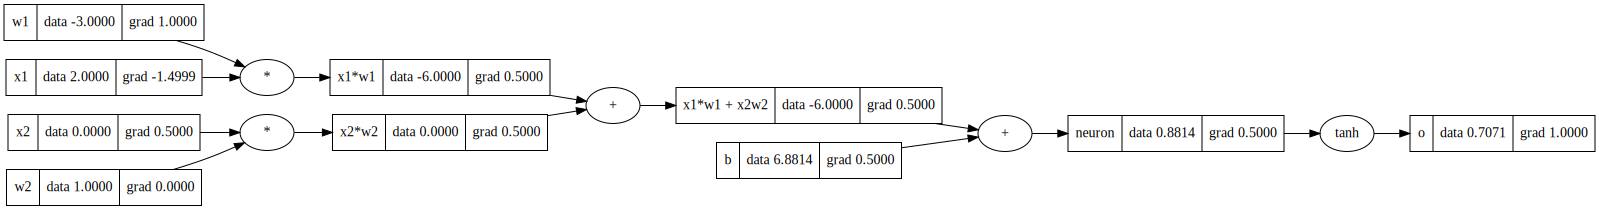

In [137]:
o.backward()
draw_dot(o)

In [138]:
# Topological sort to backpropagate from L all the way back to x1/w1/x2/w2
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

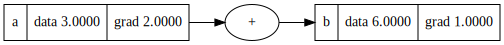

In [139]:
#example to illustrate bug when using same node twice
a = Value(3.0, label='a')
b = a + a; b.label = 'b' 
b.backward()
draw_dot(b)

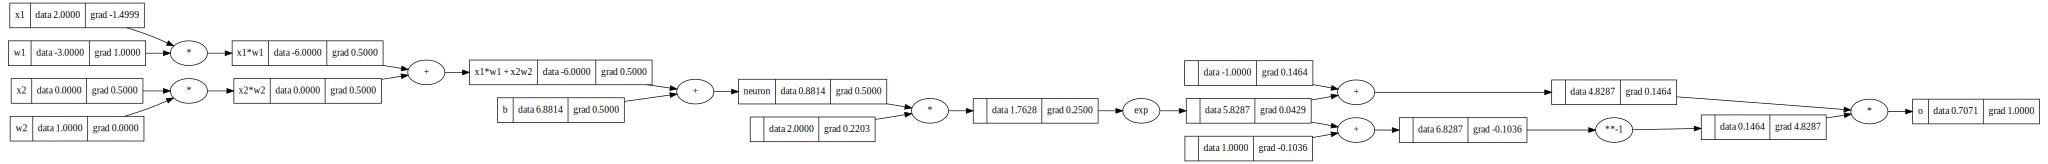

In [140]:
# Use subcomponents of tanh instead of tanh directly
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8814, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'neuron'
# -- Tanh
e = (2*n).exp()
o = (e - 1) / (e + 1)
# -- End Tanh
o.label = 'o'
o.backward()
draw_dot(o)

In [141]:
# Doing the same thing but with pytorch
import torch

x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.8813735]).double()
b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [316]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            params.extend(neuron.parameters())
        return params

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.24991475997044324)

In [321]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],   
]
ys = [1.0, -1.0, -1.0, 1.0] #desired targets

In [341]:
for k in range(10000):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)])

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update gradients
    for p in n.parameters():
        p.data += -0.5 * p.grad

In [342]:
ypred

[Value(data=0.9988654755517071),
 Value(data=-0.9987220113016259),
 Value(data=-0.9992133421261998),
 Value(data=0.9988780251095052)]